In [2]:
import pandas as pd
import numpy as np

<h2>MENU EXTRACTION CLAUDE</h2>

In [ ]:
import os
import base64
import re
from anthropic import Anthropic
from collections import defaultdict
import logging # Import logging
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def encode_image(image_path):
    """
    Encode an image file to base64.

    :param image_path: Path to the image file
    :return: Base64 encoded string of the image
    """
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        logging.error(f"Image file not found: {image_path}")
        return None
    except Exception as e:
        logging.error(f"Error encoding image {image_path}: {e}")
        return None

def extract_text_from_image(api_key, image_paths, prompt_text):
    """
    Use Claude to extract text from multiple images.

    :param api_key: Your Anthropic API key
    :param image_paths: List of paths to image files
    :param prompt_text: Text prompt for Claude
    :return: Extracted text from the images
    """
    # Initialize the Anthropic client
    client = Anthropic(api_key=api_key)

    try:
        # Create content array
        content = []

        # Add each image to the content array
        image_added = False
        for image_path in image_paths:
            # Determine media type based on file extension
            media_type = "image/jpeg"  # Default
            if image_path.lower().endswith(".png"):
                media_type = "image/png"
            elif image_path.lower().endswith(".gif"):
                media_type = "image/gif"
            elif image_path.lower().endswith(".webp"):
                 media_type = "image/webp" # Add webp support


            # Encode the image
            logging.info(f"Encoding image: {os.path.basename(image_path)}")
            base64_image = encode_image(image_path)

            if base64_image:
                # Add image to content array
                content.append({
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": media_type,
                        "data": base64_image
                    }
                })
                image_added = True
            else:
                logging.warning(f"Skipping image due to encoding error: {os.path.basename(image_path)}")

        if not image_added:
            logging.error("No images could be successfully encoded and added.")
            return None

        # Add text prompt at the end
        content.append({
            "type": "text",
            "text": prompt_text
        })

        # Send request to Claude
        logging.info("Sending request to Claude API...")
        response = client.messages.create(
            model="claude-3-haiku-20240307", # Using Haiku for speed/cost balance
            # model="claude-3-opus-20240229", # Opus might give better results but is slower/more expensive
            max_tokens=4000, # Increased max_tokens slightly
            messages=[
                {
                    "role": "user",
                    "content": content
                }
            ]
        )

        # Return the extracted text
        extracted_text = response.content[0].text
        logging.info(f"Received response from Claude. Content length: {len(extracted_text)} characters.")
        # Log first few lines of response for debugging
        # logging.debug("Claude Response Head:\n" + "\n".join(extracted_text.split('\n')[:5]))
        return extracted_text

    except Exception as e:
        logging.error(f"An error occurred during Claude API call: {e}", exc_info=True) # Log traceback
        return None

def parse_menu_items(extracted_text):
    """
    Parse menu items, prices, and categories from extracted text.

    :param extracted_text: Text extracted from the image by Claude
    :return: Dictionary of menu items {name: {'price': float, 'category': str}}, plus confidence scores {name: float}
    """
    menu_items = {}
    confidence_scores = {}

    # Basic check if extraction returned anything
    if not extracted_text or not extracted_text.strip():
        logging.warning("Received empty or null text from extraction.")
        return {}, {}

    # Split the text into lines
    lines = extracted_text.strip().split('\n')
    total_non_empty_lines = sum(1 for line in lines if line.strip())
    successful_extractions = 0
    unclear_items = 0
    default_category_items = 0

    logging.info(f"Parsing {total_non_empty_lines} non-empty lines from Claude output.")

    # --- Refined Regex Patterns ---
    # Price pattern: Handles various currency symbols (optional), commas, and decimals
    # Makes currency symbol and spacing optional. Allows integer prices.
    price_pattern = r'(?:[$€£¥]\s*|\b)(\d+(?:,\d{3})*(?:\.\d{1,2})?)\b'
    # Regex to find item name, price, and category (assumes format: NAME PRICE CATEGORY)
    # It tries to be flexible with spacing and potential currency symbols.
    # Group 1: Item Name (non-greedy)
    # Group 2: Price (using price_pattern logic)
    # Group 3: Category (rest of the line)
    # This regex is complex and might need tuning based on Claude's actual output format.
    # Let's try a simpler approach first: find price, then split.

    for line_num, line in enumerate(lines):
        line = line.strip()
        # Skip empty lines or potential headers/footers from Claude
        if not line or line.startswith("Here are the items") or line.startswith("---"):
            continue

        line_confidence = 1.0  # Start with full confidence

        # Check for uncertainty indicators in the text (global line check)
        uncertainty_phrases = ["unclear", "can't make out", "illegible", "not visible", "hard to read", "possibly", "maybe", "appears to be"]
        is_unclear = False
        for phrase in uncertainty_phrases:
            if phrase in line.lower():
                line_confidence *= 0.6  # Reduce confidence if uncertainty is indicated globally
                is_unclear = True
                # break # Found one, no need to check others for this line

        # 1. Find the price first (more reliable anchor)
        price_match = re.search(price_pattern, line)

        if price_match:
            # Extract the price and convert to float
            price_str = price_match.group(1).replace(',', '')
            try:
                price = float(price_str)
            except ValueError:
                logging.warning(f"Line {line_num+1}: Could not convert price '{price_str}' to float. Skipping line: '{line}'")
                continue

            # 2. Extract Item Name (everything before the price match)
            item_name = line[:price_match.start()].strip()
            # Clean up common trailing characters before price
            item_name = re.sub(r'[.…\-_*\s]+$', '', item_name).strip()

            # 3. Extract Category (everything after the price match)
            category_name = line[price_match.end():].strip()
            # Clean up common leading characters after price
            category_name = re.sub(r'^[.…\-_*\s]+', '', category_name).strip()

            # --- Data Cleaning and Validation ---
            # Handle empty item name (likely parsing error or header)
            if not item_name:
                 logging.warning(f"Line {line_num+1}: Extracted empty item name. Skipping line: '{line}'")
                 continue

            # Handle empty or default category
            if not category_name or category_name.lower() in ["unclear", "unknown", "n/a", "none", "-", "--"]:
                category_name = "Uncategorized" # Standardize default
                line_confidence *= 0.8 # Slightly reduce confidence if category was unclear/missing
                default_category_items += 1

            # Remove any "(unclear)" tags added by Claude from name/category
            item_name = item_name.replace("(unclear)", "").strip()
            category_name = category_name.replace("(unclear)", "").strip()

            # If the global 'unclear' flag was set, mark item count
            if is_unclear:
                unclear_items += 1


            # Check name/category quality (very short strings might be noise)
            if len(item_name) < 3:
                line_confidence *= 0.8
            if len(category_name) < 3 and category_name != "Uncategorized": # Allow short defaults
                 line_confidence *= 0.9 # Less penalty for short category

            # Check price reasonableness
            if price <= 0 or price > 1000: # Adjusted range slightly
                line_confidence *= 0.7

            # Store the item
            successful_extractions += 1
            item_key = item_name # Use name as the key

            # Handle duplicate item names (append index if price/category differ)
            if item_key in menu_items:
                 existing_item = menu_items[item_key]
                 # Only create variant if price OR category is different
                 if existing_item['price'] != price or existing_item['category'] != category_name:
                     count = 1
                     new_key = f"{item_name} ({count})"
                     while new_key in menu_items:
                         count += 1
                         new_key = f"{item_name} ({count})"
                     item_key = new_key
                     logging.info(f"Duplicate item name '{item_name}' found with different price/category. Storing as '{item_key}'.")
                 else:
                     # Exact duplicate, maybe increase confidence slightly? Or just skip. Let's skip.
                     logging.info(f"Exact duplicate item found: '{item_name}'. Skipping.")
                     successful_extractions -= 1 # Decrement success counter as we skipped it
                     continue # Skip to next line

            menu_items[item_key] = {'price': price, 'category': category_name}
            confidence_scores[item_key] = max(0.0, min(1.0, line_confidence)) # Clamp confidence 0-1

        else:
            # Line did not contain a recognizable price pattern
            logging.warning(f"Line {line_num+1}: No valid price pattern found. Skipping line: '{line}'")

    # Calculate overall extraction quality metrics
    extraction_rate = successful_extractions / total_non_empty_lines if total_non_empty_lines > 0 else 0
    avg_confidence = sum(confidence_scores.values()) / len(confidence_scores) if confidence_scores else 0

    # Log the extraction metrics
    logging.info(f"Parsing complete. Successfully extracted {successful_extractions} items.")
    logging.info(f"Extraction rate: {extraction_rate:.1%} of non-empty lines.")
    logging.info(f"Items marked unclear by Claude or parser: {unclear_items}")
    logging.info(f"Items assigned default 'Uncategorized' category: {default_category_items}")
    logging.info(f"Average confidence score for extracted items: {avg_confidence:.1%}")

    return menu_items, confidence_scores


def categorize_menu_items_with_beverage_priority(menu_items):
    """
    Categorize menu items with enhanced beverage detection and price validation.
    
    :param menu_items: Dictionary {name: {'price': float, 'category': str}}
    :return: Dictionary {category_letter: [{'name': str, 'price': float, 'category': str}, ...]}
    """
    if not menu_items:
        logging.warning("No menu items provided for categorization.")
        return {}
    
    # First, clean up any obviously wrong prices
    cleaned_menu_items = {}
    for name, item_data in menu_items.items():
        price = item_data['price']
        
        # Check for unreasonable prices (over 500 baht for a menu item)
        if price > 500:
            logging.warning(f"Found potentially incorrect price for {name}: ${price:.2f}")
            
            # Extract price from item name if possible
            price_match = re.search(r'฿(\d+)', name)
            if price_match:
                corrected_price = float(price_match.group(1))
                logging.info(f"Corrected price from name for {name}: ${corrected_price:.2f}")
                item_data['price'] = corrected_price
        
        cleaned_menu_items[name] = item_data
    
    # Prepare items list
    items_list = [{'name': name, **data} for name, data in cleaned_menu_items.items()]
    
    # Initialize categories
    alcoholic_beverages = []
    non_alcoholic_beverages = []
    other_items = []
    
    # Process each menu item
    for item in items_list:
        name = item['name'].lower()
        category = item['category'].lower() if item['category'] else ''
        
        # DEFINITIVE RULES FOR NON-ALCOHOLIC BEVERAGES
        if ('pepsi' in name or 
            'coca' in name or 
            'sprite' in name or 
            'fanta' in name or 
            'juice' in name or 
            'soda' in name or 
            'water' in name or 
            'tea' in name or 
            'coffee' in name or 
            'น้ำ' in name or  # Thai for water/drink
            'fizz' in name or 
            'mocktail' in name or 
            'peony' in name or 
            'blue asian' in name or 
            'tropical summer' in name or 
            'yu-ney' in name or 
            'freshy island' in name or 
            'chrysanthemum' in name or 
            'grass jelly' in name):
            
            # EXCLUSIONS: Food items with drink words
            if ('soup' in name or 'dessert' in category.lower() or 
                'ginkgo' in name or 'bua loi' in name or 'rice' in name):
                other_items.append(item)
            else:
                # Ensure correct category
                item['category'] = 'Non-Alcoholic Beverage'
                non_alcoholic_beverages.append(item)
            continue
            
        # SPECIAL CASE: Santa Vittoria
        if 'santa vittoria' in name or 'ซานตา วิตตอเรีย' in name:
            # Santa Vittoria is mineral water (non-alcoholic), whether sparkling or still
            item['category'] = 'Non-Alcoholic Beverage'
            non_alcoholic_beverages.append(item)
            continue
            
        # DEFINITIVE RULES FOR ALCOHOLIC BEVERAGES
        if ('beer' in name or 
            'เบียร์' in name or 
            'singha' in name or 
            'tsingtao' in name or 
            'สิงห์' in name or 
            'ชิงเต่า' in name or 
            'wine' in name or 
            'whisky' in name or 
            'whiskey' in name or 
            'vodka' in name or 
            'gin' in name or 
            'rum' in name or 
            'tequila' in name or 
            'dimple' in name):
                
            # Ensure correct category
            item['category'] = 'Alcoholic Beverage'
            alcoholic_beverages.append(item)
            continue
            
        # Use category information as fallback
        if 'beverage' in category:
            if 'alcoholic' in category:
                alcoholic_beverages.append(item)
            else:
                non_alcoholic_beverages.append(item)
        else:
            # Not a beverage or not clearly identified
            other_items.append(item)
    
    # Create result categories dict
    categories = {}
    
    # Assign alcoholic beverages to category Z
    if alcoholic_beverages:
        categories['Z'] = sorted(alcoholic_beverages, key=lambda x: x['price'], reverse=True)
        
    # Assign non-alcoholic beverages to category Y
    if non_alcoholic_beverages:
        categories['Y'] = sorted(non_alcoholic_beverages, key=lambda x: x['price'], reverse=True)
    
    # Apply dynamic price categorization to non-beverage items
    if other_items:
        # Sort by price (descending)
        sorted_items = sorted(other_items, key=lambda x: x['price'], reverse=True)
        
        # Setup thresholds
        expensive_threshold_ratio = 1.3  # 30% difference
        inexpensive_threshold_ratio = 2.0  # 2x difference
        
        # Price below which we switch threshold
        switch_threshold = sorted_items[0]['price'] / 2 if sorted_items else 0
        
        # Keep track of remaining items to categorize
        remaining_items = sorted_items.copy()
        current_category = 0  # Start with category A (0)
        
        while remaining_items:
            current_category_letter = chr(65 + current_category)  # A, B, C, ...
            category_items = []
            
            # Add the first item to the current category
            first_item = remaining_items.pop(0)
            category_items.append(first_item)
            highest_price = lowest_price = first_item['price']
            
            # Determine which threshold to use
            threshold_ratio = expensive_threshold_ratio if highest_price >= switch_threshold else inexpensive_threshold_ratio
            
            # Add more items within threshold
            while remaining_items:
                next_item = remaining_items[0]
                next_price = next_item['price']
                
                if highest_price / next_price > threshold_ratio:
                    break
                
                category_items.append(remaining_items.pop(0))
                lowest_price = next_price
            
            # Store the category
            categories[current_category_letter] = category_items
            
            # Prepare for next category
            current_category += 1
            
            # Adjust threshold if needed
            if remaining_items and remaining_items[0]['price'] < switch_threshold:
                threshold_ratio = inexpensive_threshold_ratio
    
    # Log the categorization results
    logging.info("\n--- Final Categorization Results ---")
    for category_letter, items in sorted(categories.items()):
        category_type = "Alcoholic Beverages" if category_letter == 'Z' else \
                       "Non-Alcoholic Beverages" if category_letter == 'Y' else \
                       f"Price Category"
        price_range = f"${min(item['price'] for item in items):.2f} - ${max(item['price'] for item in items):.2f}" if items else "N/A"
        logging.info(f"Category {category_letter} ({category_type}): {len(items)} items. Price range: {price_range}")
        for item in items:
            logging.info(f"  ${item['price']:.2f} - {item['name']}")
    
    return categories


def process_menu_images(api_key, image_folder, num_price_categories=3):
    """
    Process all menu images in a folder, extract items (name, price, category),
    and categorize them by price tiers (A, B, C...).

    :param api_key: Your Anthropic API key
    :param image_folder: Path to folder containing menu images
    :param num_price_categories: Number of price categories (A, B, C...)
    :return: Price-categorized menu items dict, and overall confidence scores dict
    """
    # List all image files in the folder
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.webp'] # Added webp
    image_paths = []

    if not os.path.isdir(image_folder):
        logging.error(f"Image folder not found or is not a directory: {image_folder}")
        return {}, {}

    for file in os.listdir(image_folder):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_paths.append(os.path.join(image_folder, file))

    if not image_paths:
        logging.error(f"No supported image files ({', '.join(image_extensions)}) found in {image_folder}")
        return {}, {}

    logging.info(f"Found {len(image_paths)} images to process in folder: {image_folder}")

    # Store all items extracted across all images before final categorization
    # Using the structure: {name: {'price': float, 'category': str}}
    all_menu_items_combined = {}
    all_confidence_scores_combined = {}
    image_extraction_counts = []

    # --- Updated Prompt for Claude ---
    prompt_text = f"""
    Please extract all menu items from the provided image(s).

For each distinct menu item found, provide the following information on a single line:
1. The complete Item Name in English (if available).
2. The Thai name of the item (if available).
3. If only Thai OR only English name is available, just extract what is present and mark the other blank
4. The exact Price (including currency symbol like $ or ฿ if visible, otherwise just the number).
5. The item's Category (e.g., Appetizer, Main Course, Dessert, Beverage, Side Dish).

Format each item STRICTLY as:
English Item Name Thai Item Name $Price Category

Examples (menu item is available in both english and thai):
Classic Caesar Salad ซีซาร์สลัดคลาสสิค $12.99 Appetizer
Grilled Salmon Fillet ปลาแซลมอนย่าง $24.50 Main Course
New York Cheesecake นิวยอร์กชีสเค้ก $8.00 Dessert
Iced Tea ชาเย็น $3.50 Beverage
French Fries เฟรนช์ฟรายส์ $5.00 Side Dish

Examples (menu item is only available in english):
Pad Thai $12.99 Main Course
Classic Caesar Salad $12.99 Appetizer
Grilled Salmon Fillet $24.50 Main Course
New York Cheesecake $8.00 Dessert
Iced Tea $3.50 Beverage
French Fries $5.00 Side Dish

Examples (menu item is only available in thai):
ผัดไทย $12.99 Main Course
ซีซาร์สลัดคลาสสิค $12.99 Appetizer
ปลาแซลมอนย่าง $24.50 Main Course
นิวยอร์กชีสเค้ก $8.00 Dessert
ชาเย็น $3.50 Beverage
เฟรนช์ฟรายส์ $5.00 Side Dish

IMPORTANT INSTRUCTIONS:
- List EVERY visible menu item, and do not include the menu item details.
- If you cannot clearly determine any part (Price or Category), use the placeholder "(unclear)" for that specific part.
- If the category is totally unknown, use "Uncategorized".
- Ensure the price is extracted accurately.
- Do NOT add any introductory text, explanations, summaries, or formatting like bullet points or markdown.
- Only output the list of items in the specified format, one item per line.
- If an item seems to span multiple lines in the menu image, combine it into a single logical item name if possible.
- Pay attention to sections or headers in the menu image to help determine the category.

CRITICAL BEVERAGE CATEGORIZATION INSTRUCTIONS:
- You MUST correctly identify ALL beverages and categorize them properly:
  * ALL beers (Singha, Tsingtao, Chang, etc.) MUST be labeled as "Alcoholic Beverage"
  * ALL wines, spirits, whiskeys, cocktails MUST be labeled as "Alcoholic Beverage"
  * ALL sodas, juices, teas, coffees, mocktails MUST be labeled as "Non-Alcoholic Beverage"
  * Santa Vittoria Sparkling is alcoholic, regular Santa Vittoria is non-alcoholic water

EXAMPLES OF CORRECT BEVERAGE CATEGORIZATION:
Tsingtao Beer 青岛啤酒 $130.00 Alcoholic Beverage
Singha Beer สิงห์เบียร์ $110.00 Alcoholic Beverage
Pepsi $30.00 Non-Alcoholic Beverage
Orange Juice $80.00 Non-Alcoholic Beverage
Coffee ชาเย็น $75.00 Non-Alcoholic Beverage
Wine ไวน์ $220.00 Alcoholic Beverage
    """

    # Process images (can be done one-by-one or batched if API/model supports it well)
    # Let's stick to one-by-one for simplicity and robustness against single image failures.
    for idx, image_path in enumerate(image_paths):
        logging.info(f"\n--- Processing image {idx+1}/{len(image_paths)}: {os.path.basename(image_path)} ---")

        extracted_text = extract_text_from_image(api_key, [image_path], prompt_text)

        if extracted_text:
            logging.info(f"Text extraction successful for {os.path.basename(image_path)}. Parsing content...")

            # Parse menu items (name, price, category) from this image's text
            menu_items_single, confidence_scores_single = parse_menu_items(extracted_text)
            item_count_single = len(menu_items_single)
            logging.info(f"Parsed {item_count_single} items from {os.path.basename(image_path)}.")
            image_extraction_counts.append((os.path.basename(image_path), item_count_single))

            # Merge items from this image into the combined dictionary
            for item_name, item_data in menu_items_single.items():
                confidence = confidence_scores_single.get(item_name, 0.5) # Default confidence if missing

                # Check if item already exists in combined list
                if item_name in all_menu_items_combined:
                    existing_data = all_menu_items_combined[item_name]
                    # If price or category differs, create a variant
                    if existing_data['price'] != item_data['price'] or existing_data['category'] != item_data['category']:
                        variant_count = 1
                        variant_name = f"{item_name} (Img {idx+1})" # Add image source to variant name
                        while variant_name in all_menu_items_combined:
                             variant_count += 1
                             variant_name = f"{item_name} (Img {idx+1} Var {variant_count})"

                        logging.warning(f"Item '{item_name}' from {os.path.basename(image_path)} differs from previous entry. Storing as '{variant_name}'. "
                                        f"Old: P={existing_data['price']}, C='{existing_data['category']}'. New: P={item_data['price']}, C='{item_data['category']}'.")
                        all_menu_items_combined[variant_name] = item_data
                        all_confidence_scores_combined[variant_name] = confidence
                    else:
                         # Exact same item found again, potentially update confidence if higher?
                         # For now, let's keep the first encountered confidence.
                         logging.info(f"Item '{item_name}' is an exact duplicate from another image. Skipping.")
                else:
                    # New item, add it
                    all_menu_items_combined[item_name] = item_data
                    all_confidence_scores_combined[item_name] = confidence

            logging.info(f"Combined total unique items so far: {len(all_menu_items_combined)}")
        else:
            logging.error(f"Failed to extract text from {os.path.basename(image_path)}. Skipping this image.")
            image_extraction_counts.append((os.path.basename(image_path), 0)) # Record failure

    # --- Post-Processing and Categorization ---
    logging.info(f"\n===== Image Processing Summary =====")
    total_items_extracted = sum(count for _, count in image_extraction_counts)
    logging.info(f"Total items parsed across all images (before deduplication/variants): {total_items_extracted}")
    logging.info(f"Final unique items/variants stored: {len(all_menu_items_combined)}")

    # Print extraction performance by image
    logging.info("\nItems Parsed Per Image:")
    for image_name, item_count in image_extraction_counts:
        logging.info(f"  {image_name}: {item_count} items")

    # Calculate overall average confidence score
    if all_confidence_scores_combined:
        avg_confidence = sum(all_confidence_scores_combined.values()) / len(all_confidence_scores_combined)
        logging.info(f"Overall average extraction confidence: {avg_confidence:.1%}")
    else:
         logging.info("No confidence scores available.")


    if not all_menu_items_combined:
        logging.error("No menu items were successfully extracted from any images.")
        return {}, {}


    # Categorize the combined menu items by price tiers (A, B, C...)
    logging.info("\n--- Categorizing All Extracted Items by Price ---")
    final_categories = categorize_menu_items_with_beverage_priority(all_menu_items_combined)

    return final_categories, all_confidence_scores_combined

def main():
    # --- Configuration ---
    # IMPORTANT: Replace with your actual Anthropic API key
    # Consider using environment variables for API keys in production
    API_KEY = os.environ.get('ANTHROPIC_API_KEY') # Looks for env var first

    if not API_KEY:
        logging.error("CRITICAL: Anthropic API key not found. Set the ANTHROPIC_API_KEY environment variable or replace 'YOUR_API_KEY_HERE' in the script.")
        return

    # Path to your folder containing menu images
    IMAGE_FOLDER = './sample/THAI MENUS/Zalid Kitchen' # Make sure this folder exists and contains images

    # Output file name
    OUTPUT_FILENAME = "categorized_menu_items.txt"
    # --- End Configuration ---


    logging.info("===== MENU ITEM EXTRACTION AND PRICE CATEGORIZATION =====")
    logging.info(f"Processing menu images from folder: {os.path.abspath(IMAGE_FOLDER)}")

    # Create image folder if it doesn't exist (useful for first run)
    if not os.path.exists(IMAGE_FOLDER):
        try:
            os.makedirs(IMAGE_FOLDER)
            logging.info(f"Created image folder: {IMAGE_FOLDER}")
            logging.warning("Image folder was created, but it's currently empty. Please add menu images to it.")
            return # Stop execution if folder was just created empty
        except OSError as e:
            logging.error(f"Failed to create image folder {IMAGE_FOLDER}: {e}")
            return


    # Process menu images
    price_categories, confidence_scores = process_menu_images(API_KEY, IMAGE_FOLDER)

    if price_categories:
        # --- Output Results ---
        menu_rows = []
        for category_letter, items in sorted(price_categories.items()):
            if items:
                # Sort items within the category by price (desc) for writing
                items_sorted = sorted(items, key=lambda x: x['price'], reverse=True)

                for item_dict in items_sorted:
                    menu_rows.append({
                        'Category': item_dict['category'],
                        'Name': item_dict['name'],
                        'Price': item_dict['price']
                    })

        ocr_df = pd.DataFrame(menu_rows, columns=['Category', 'Name', 'Price'])
        return ocr_df
    else:
        logging.error("Processing finished, but no menu items were found or categorized.")

if __name__ == "__main__":
    ocr_df = main()


<h2>Gemini OCR Extraction</h2>

In [8]:
import os
import base64
import re
from google import generativeai as genai
from collections import defaultdict
import logging
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def encode_image(image_path):
    """
    Encode an image file to base64.

    :param image_path: Path to the image file
    :return: Base64 encoded string of the image
    """
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        logging.error(f"Image file not found: {image_path}")
        return None
    except Exception as e:
        logging.error(f"Error encoding image {image_path}: {e}")
        return None

def extract_text_from_image(api_key, image_paths, prompt_text):
    """
    Use Gemini to extract text from multiple images.

    :param api_key: Your Google API key
    :param image_paths: List of paths to image files
    :param prompt_text: Text prompt for Gemini
    :return: Extracted text from the images
    """
    # Configure the Gemini API
    try:
        genai.configure(api_key=api_key)
    except Exception as e:
        logging.error(f"Error configuring Gemini API: {e}")
        return None

    try:
        # Initialize the Gemini model
        model = genai.GenerativeModel('gemini-1.5-pro-latest')

        # Prepare parts for the request
        parts = []
        image_added = False
        
        # Process each image
        for image_path in image_paths:
            try:
                # Read the image file directly
                with open(image_path, "rb") as image_file:
                    image_data = image_file.read()
                
                # Determine mime type based on file extension
                ext = os.path.splitext(image_path)[1][1:].lower()
                mime_type = "image/jpeg"  # Default
                if ext == "png":
                    mime_type = "image/png"
                elif ext == "gif":
                    mime_type = "image/gif"
                elif ext == "webp":
                    mime_type = "image/webp"
                
                # Add image to parts
                parts.append({
                    "inline_data": {
                        "mime_type": mime_type,
                        "data": base64.b64encode(image_data).decode('utf-8')
                    }
                })
                image_added = True
                logging.info(f"Added image: {os.path.basename(image_path)}")
            except Exception as e:
                logging.warning(f"Error processing image {image_path}: {e}")
        
        if not image_added:
            logging.error("No images could be successfully processed.")
            return None
        
        # Add the text prompt
        parts.append({"text": prompt_text})

        # Send request to Gemini
        logging.info("Sending request to Gemini API...")
        response = model.generate_content(
            parts,
            generation_config=genai.types.GenerationConfig(
                max_output_tokens=4000,
                temperature=0.2,
                top_p=0.8,
            )
        )

        # Extract and return the text response
        if response and hasattr(response, 'text'):
            extracted_text = response.text
            logging.info(f"Received response from Gemini. Content length: {len(extracted_text)} characters.")
            return extracted_text
        else:
            logging.error("Received empty or unexpected response format from Gemini.")
            return None

    except Exception as e:
        logging.error(f"An error occurred during Gemini API call: {e}", exc_info=True)
        return None

def parse_menu_items(extracted_text):
    """
    Parse menu items, prices, and categories from extracted text.

    :param extracted_text: Text extracted from the image by Gemini
    :return: Dictionary of menu items {name: {'price': float, 'category': str}}, plus confidence scores {name: float}
    """
    menu_items = {}
    confidence_scores = {}

    # Basic check if extraction returned anything
    if not extracted_text or not extracted_text.strip():
        logging.warning("Received empty or null text from extraction.")
        return {}, {}

    # Split the text into lines
    lines = extracted_text.strip().split('\n')
    total_non_empty_lines = sum(1 for line in lines if line.strip())
    successful_extractions = 0
    unclear_items = 0
    default_category_items = 0

    logging.info(f"Parsing {total_non_empty_lines} non-empty lines from Gemini output.")

    # --- Refined Regex Patterns ---
    # Price pattern: Handles various currency symbols (optional), commas, and decimals
    # Makes currency symbol and spacing optional. Allows integer prices.
    price_pattern = r'(?:[$€£¥]\s*|\b)(\d+(?:,\d{3})*(?:\.\d{1,2})?)\b'

    for line_num, line in enumerate(lines):
        line = line.strip()
        # Skip empty lines or potential headers/footers from Gemini
        if not line or line.startswith("Here are the items") or line.startswith("---"):
            continue

        line_confidence = 1.0  # Start with full confidence

        # Check for uncertainty indicators in the text (global line check)
        uncertainty_phrases = ["unclear", "can't make out", "illegible", "not visible", "hard to read", "possibly", "maybe", "appears to be"]
        is_unclear = False
        for phrase in uncertainty_phrases:
            if phrase in line.lower():
                line_confidence *= 0.6  # Reduce confidence if uncertainty is indicated globally
                is_unclear = True

        # 1. Find the price first (more reliable anchor)
        price_match = re.search(price_pattern, line)

        if price_match:
            # Extract the price and convert to float
            price_str = price_match.group(1).replace(',', '')
            try:
                price = float(price_str)
            except ValueError:
                logging.warning(f"Line {line_num+1}: Could not convert price '{price_str}' to float. Skipping line: '{line}'")
                continue

            # 2. Extract Item Name (everything before the price match)
            item_name = line[:price_match.start()].strip()
            # Clean up common trailing characters before price
            item_name = re.sub(r'[.…\-_*\s]+$', '', item_name).strip()

            # 3. Extract Category (everything after the price match)
            category_name = line[price_match.end():].strip()
            # Clean up common leading characters after price
            category_name = re.sub(r'^[.…\-_*\s]+', '', category_name).strip()

            # --- Data Cleaning and Validation ---
            # Handle empty item name (likely parsing error or header)
            if not item_name:
                 logging.warning(f"Line {line_num+1}: Extracted empty item name. Skipping line: '{line}'")
                 continue

            # Handle empty or default category
            if not category_name or category_name.lower() in ["unclear", "unknown", "n/a", "none", "-", "--"]:
                category_name = "Uncategorized" # Standardize default
                line_confidence *= 0.8 # Slightly reduce confidence if category was unclear/missing
                default_category_items += 1

            # Remove any "(unclear)" tags added by Gemini from name/category
            item_name = item_name.replace("(unclear)", "").strip()
            category_name = category_name.replace("(unclear)", "").strip()

            # If the global 'unclear' flag was set, mark item count
            if is_unclear:
                unclear_items += 1

            # Check name/category quality (very short strings might be noise)
            if len(item_name) < 3:
                line_confidence *= 0.8
            if len(category_name) < 3 and category_name != "Uncategorized": # Allow short defaults
                 line_confidence *= 0.9 # Less penalty for short category

            # Check price reasonableness
            if price <= 0 or price > 1000: # Adjusted range slightly
                line_confidence *= 0.7

            # Store the item
            successful_extractions += 1
            item_key = item_name # Use name as the key

            # Handle duplicate item names (append index if price/category differ)
            if item_key in menu_items:
                 existing_item = menu_items[item_key]
                 # Only create variant if price OR category is different
                 if existing_item['price'] != price or existing_item['category'] != category_name:
                     count = 1
                     new_key = f"{item_name} ({count})"
                     while new_key in menu_items:
                         count += 1
                         new_key = f"{item_name} ({count})"
                     item_key = new_key
                     logging.info(f"Duplicate item name '{item_name}' found with different price/category. Storing as '{item_key}'.")
                 else:
                     # Exact duplicate, maybe increase confidence slightly? Or just skip. Let's skip.
                     logging.info(f"Exact duplicate item found: '{item_name}'. Skipping.")
                     successful_extractions -= 1 # Decrement success counter as we skipped it
                     continue # Skip to next line

            menu_items[item_key] = {'price': price, 'category': category_name}
            confidence_scores[item_key] = max(0.0, min(1.0, line_confidence)) # Clamp confidence 0-1

        else:
            # Line did not contain a recognizable price pattern
            logging.warning(f"Line {line_num+1}: No valid price pattern found. Skipping line: '{line}'")

    # Calculate overall extraction quality metrics
    extraction_rate = successful_extractions / total_non_empty_lines if total_non_empty_lines > 0 else 0
    avg_confidence = sum(confidence_scores.values()) / len(confidence_scores) if confidence_scores else 0

    # Log the extraction metrics
    logging.info(f"Parsing complete. Successfully extracted {successful_extractions} items.")
    logging.info(f"Extraction rate: {extraction_rate:.1%} of non-empty lines.")
    logging.info(f"Items marked unclear by Gemini or parser: {unclear_items}")
    logging.info(f"Items assigned default 'Uncategorized' category: {default_category_items}")
    logging.info(f"Average confidence score for extracted items: {avg_confidence:.1%}")

    return menu_items, confidence_scores


def categorize_menu_items_with_beverage_priority(menu_items):
    """
    Categorize menu items with enhanced beverage detection and price validation.
    
    :param menu_items: Dictionary {name: {'price': float, 'category': str}}
    :return: Dictionary {category_letter: [{'name': str, 'price': float, 'category': str}, ...]}
    """
    if not menu_items:
        logging.warning("No menu items provided for categorization.")
        return {}
    
    # First, clean up any obviously wrong prices
    cleaned_menu_items = {}
    for name, item_data in menu_items.items():
        price = item_data['price']
        
        # Fix zero or negative prices (invalid data)
        if price <= 0:
            logging.warning(f"Found invalid price for {name}: ${price:.2f}, setting to minimum price of $1.00")
            item_data['price'] = 1.0  # Set a minimum price to avoid division by zero
        
        # Check for unreasonable prices (over 500 baht for a menu item)
        elif price > 500:
            logging.warning(f"Found potentially incorrect price for {name}: ${price:.2f}")
            
            # Extract price from item name if possible
            price_match = re.search(r'฿(\d+)', name)
            if price_match:
                corrected_price = float(price_match.group(1))
                logging.info(f"Corrected price from name for {name}: ${corrected_price:.2f}")
                item_data['price'] = corrected_price
        
        cleaned_menu_items[name] = item_data
    
    # Prepare items list
    items_list = [{'name': name, **data} for name, data in cleaned_menu_items.items()]
    
    # Initialize categories
    alcoholic_beverages = []
    non_alcoholic_beverages = []
    other_items = []
    
    # Process each menu item
    for item in items_list:
        name = item['name'].lower()
        category = item['category'].lower() if item['category'] else ''
        
        # DEFINITIVE RULES FOR NON-ALCOHOLIC BEVERAGES
        if ('pepsi' in name or 
            'coca' in name or 
            'sprite' in name or 
            'fanta' in name or 
            'juice' in name or 
            'soda' in name or 
            'water' in name or 
            'tea' in name or 
            'coffee' in name or 
            'น้ำ' in name or  # Thai for water/drink
            'fizz' in name or 
            'mocktail' in name or 
            'peony' in name or 
            'blue asian' in name or 
            'tropical summer' in name or 
            'yu-ney' in name or 
            'freshy island' in name or 
            'chrysanthemum' in name or 
            'grass jelly' in name):
            
            # EXCLUSIONS: Food items with drink words
            if ('soup' in name or 'dessert' in category.lower() or 
                'ginkgo' in name or 'bua loi' in name or 'rice' in name):
                other_items.append(item)
            else:
                # Ensure correct category
                item['category'] = 'Non-Alcoholic Beverage'
                non_alcoholic_beverages.append(item)
            continue
            
        # SPECIAL CASE: Santa Vittoria
        if 'santa vittoria' in name or 'ซานตา วิตตอเรีย' in name:
            # Santa Vittoria is mineral water (non-alcoholic), whether sparkling or still
            item['category'] = 'Non-Alcoholic Beverage'
            non_alcoholic_beverages.append(item)
            continue
            
        # DEFINITIVE RULES FOR ALCOHOLIC BEVERAGES
        if ('beer' in name or 
            'เบียร์' in name or 
            'singha' in name or 
            'tsingtao' in name or 
            'สิงห์' in name or 
            'ชิงเต่า' in name or 
            'wine' in name or 
            'whisky' in name or 
            'whiskey' in name or 
            'vodka' in name or 
            'gin' in name or 
            'rum' in name or 
            'tequila' in name or 
            'dimple' in name):
                
            # Ensure correct category
            item['category'] = 'Alcoholic Beverage'
            alcoholic_beverages.append(item)
            continue
            
        # Use category information as fallback
        if 'beverage' in category:
            if 'alcoholic' in category:
                alcoholic_beverages.append(item)
            else:
                non_alcoholic_beverages.append(item)
        else:
            # Not a beverage or not clearly identified
            other_items.append(item)
    
    # Create result categories dict
    categories = {}
    
    # Assign alcoholic beverages to category Z
    if alcoholic_beverages:
        categories['Z'] = sorted(alcoholic_beverages, key=lambda x: x['price'], reverse=True)
        
    # Assign non-alcoholic beverages to category Y
    if non_alcoholic_beverages:
        categories['Y'] = sorted(non_alcoholic_beverages, key=lambda x: x['price'], reverse=True)
    
    # Apply dynamic price categorization to non-beverage items
    if other_items:
        # Sort by price (descending)
        sorted_items = sorted(other_items, key=lambda x: x['price'], reverse=True)
        
        # Setup thresholds
        expensive_threshold_ratio = 1.3  # 30% difference
        inexpensive_threshold_ratio = 2.0  # 2x difference
        
        # Price below which we switch threshold
        switch_threshold = sorted_items[0]['price'] / 2 if sorted_items else 0
        
        # Keep track of remaining items to categorize
        remaining_items = sorted_items.copy()
        current_category = 0  # Start with category A (0)
        
        while remaining_items:
            current_category_letter = chr(65 + current_category)  # A, B, C, ...
            category_items = []
            
            # Add the first item to the current category
            first_item = remaining_items.pop(0)
            category_items.append(first_item)
            highest_price = lowest_price = first_item['price']
            
            # Determine which threshold to use
            threshold_ratio = expensive_threshold_ratio if highest_price >= switch_threshold else inexpensive_threshold_ratio
            
            # Add more items within threshold
            while remaining_items:
                next_item = remaining_items[0]
                next_price = next_item['price']
                
                # Prevent division by zero
                if next_price <= 0:
                    logging.warning(f"Item '{next_item['name']}' has invalid price ${next_price:.2f}. Moving to next item.")
                    remaining_items.pop(0)  # Remove this item and continue
                    continue
                
                if highest_price / next_price > threshold_ratio:
                    break
                
                category_items.append(remaining_items.pop(0))
                lowest_price = next_price
            
            # Store the category
            categories[current_category_letter] = category_items
            
            # Prepare for next category
            current_category += 1
            
            # Adjust threshold if needed
            if remaining_items and remaining_items[0]['price'] < switch_threshold:
                threshold_ratio = inexpensive_threshold_ratio
    
    # Log the categorization results
    logging.info("\n--- Final Categorization Results ---")
    for category_letter, items in sorted(categories.items()):
        if not items:
            continue  # Skip empty categories
            
        category_type = "Alcoholic Beverages" if category_letter == 'Z' else \
                       "Non-Alcoholic Beverages" if category_letter == 'Y' else \
                       f"Price Category"
        price_range = f"${min(item['price'] for item in items):.2f} - ${max(item['price'] for item in items):.2f}" if items else "N/A"
        logging.info(f"Category {category_letter} ({category_type}): {len(items)} items. Price range: {price_range}")
        for item in items:
            logging.info(f"  ${item['price']:.2f} - {item['name']}")
    
    return categories


def process_menu_images(api_key, image_folder, num_price_categories=3):
    """
    Process all menu images in a folder, extract items (name, price, category),
    and categorize them by price tiers (A, B, C...).

    :param api_key: Your Gemini API key
    :param image_folder: Path to folder containing menu images
    :param num_price_categories: Number of price categories (A, B, C...)
    :return: Price-categorized menu items dict, and overall confidence scores dict
    """
    # List all image files in the folder
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.webp'] # Added webp
    image_paths = []

    if not os.path.isdir(image_folder):
        logging.error(f"Image folder not found or is not a directory: {image_folder}")
        return {}, {}

    for file in os.listdir(image_folder):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_paths.append(os.path.join(image_folder, file))

    if not image_paths:
        logging.error(f"No supported image files ({', '.join(image_extensions)}) found in {image_folder}")
        return {}, {}

    logging.info(f"Found {len(image_paths)} images to process in folder: {image_folder}")

    # Store all items extracted across all images before final categorization
    # Using the structure: {name: {'price': float, 'category': str}}
    all_menu_items_combined = {}
    all_confidence_scores_combined = {}
    image_extraction_counts = []

    # --- Updated Prompt for Gemini ---
    prompt_text = f"""
    Please extract all menu items from the provided image(s).

For each distinct menu item found, provide the following information on a single line:
1. The complete Item Name in English (if available).
2. The Thai name of the item (if available).
3. If only Thai OR only English name is available, just extract what is present and mark the other blank
4. The exact Price (including currency symbol like $ or ฿ if visible, otherwise just the number).
5. The item's Category (e.g., Appetizer, Main Course, Dessert, Beverage, Side Dish).

Format each item STRICTLY as:
English Item Name Thai Item Name $Price Category

Examples (menu item is available in both english and thai):
Classic Caesar Salad ซีซาร์สลัดคลาสสิค $12.99 Appetizer
Grilled Salmon Fillet ปลาแซลมอนย่าง $24.50 Main Course
New York Cheesecake นิวยอร์กชีสเค้ก $8.00 Dessert
Iced Tea ชาเย็น $3.50 Beverage
French Fries เฟรนช์ฟรายส์ $5.00 Side Dish

Examples (menu item is only available in english):
Pad Thai $12.99 Main Course
Classic Caesar Salad $12.99 Appetizer
Grilled Salmon Fillet $24.50 Main Course
New York Cheesecake $8.00 Dessert
Iced Tea $3.50 Beverage
French Fries $5.00 Side Dish

Examples (menu item is only available in thai):
ผัดไทย $12.99 Main Course
ซีซาร์สลัดคลาสสิค $12.99 Appetizer
ปลาแซลมอนย่าง $24.50 Main Course
นิวยอร์กชีสเค้ก $8.00 Dessert
ชาเย็น $3.50 Beverage
เฟรนช์ฟรายส์ $5.00 Side Dish

IMPORTANT INSTRUCTIONS:
- List EVERY visible menu item, and do not include the menu item details.
- If you cannot clearly determine any part (Price or Category), use the placeholder "(unclear)" for that specific part.
- If the category is totally unknown, use "Uncategorized".
- Ensure the price is extracted accurately.
- Do NOT add any introductory text, explanations, summaries, or formatting like bullet points or markdown.
- Only output the list of items in the specified format, one item per line.
- If an item seems to span multiple lines in the menu image, combine it into a single logical item name if possible.
- Pay attention to sections or headers in the menu image to help determine the category.

CRITICAL BEVERAGE CATEGORIZATION INSTRUCTIONS:
- You MUST correctly identify ALL beverages and categorize them properly:
  * ALL beers (Singha, Tsingtao, Chang, etc.) MUST be labeled as "Alcoholic Beverage"
  * ALL wines, spirits, whiskeys, cocktails MUST be labeled as "Alcoholic Beverage"
  * ALL sodas, juices, teas, coffees, mocktails MUST be labeled as "Non-Alcoholic Beverage"
  * Santa Vittoria Sparkling is alcoholic, regular Santa Vittoria is non-alcoholic water

EXAMPLES OF CORRECT BEVERAGE CATEGORIZATION:
Tsingtao Beer 青岛啤酒 $130.00 Alcoholic Beverage
Singha Beer สิงห์เบียร์ $110.00 Alcoholic Beverage
Pepsi $30.00 Non-Alcoholic Beverage
Orange Juice $80.00 Non-Alcoholic Beverage
Coffee ชาเย็น $75.00 Non-Alcoholic Beverage
Wine ไวน์ $220.00 Alcoholic Beverage
    """

    # Process images (can be done one-by-one or batched if API/model supports it well)
    # Let's stick to one-by-one for simplicity and robustness against single image failures.
    for idx, image_path in enumerate(image_paths):
        logging.info(f"\n--- Processing image {idx+1}/{len(image_paths)}: {os.path.basename(image_path)} ---")

        extracted_text = extract_text_from_image(api_key, [image_path], prompt_text)

        if extracted_text:
            logging.info(f"Text extraction successful for {os.path.basename(image_path)}. Parsing content...")

            # Parse menu items (name, price, category) from this image's text
            menu_items_single, confidence_scores_single = parse_menu_items(extracted_text)
            item_count_single = len(menu_items_single)
            logging.info(f"Parsed {item_count_single} items from {os.path.basename(image_path)}.")
            image_extraction_counts.append((os.path.basename(image_path), item_count_single))

            # Merge items from this image into the combined dictionary
            for item_name, item_data in menu_items_single.items():
                confidence = confidence_scores_single.get(item_name, 0.5) # Default confidence if missing

                # Check if item already exists in combined list
                if item_name in all_menu_items_combined:
                    existing_data = all_menu_items_combined[item_name]
                    # If price or category differs, create a variant
                    if existing_data['price'] != item_data['price'] or existing_data['category'] != item_data['category']:
                        variant_count = 1
                        variant_name = f"{item_name} (Img {idx+1})" # Add image source to variant name
                        while variant_name in all_menu_items_combined:
                             variant_count += 1
                             variant_name = f"{item_name} (Img {idx+1} Var {variant_count})"

                        logging.warning(f"Item '{item_name}' from {os.path.basename(image_path)} differs from previous entry. Storing as '{variant_name}'. "
                                        f"Old: P={existing_data['price']}, C='{existing_data['category']}'. New: P={item_data['price']}, C='{item_data['category']}'.")
                        all_menu_items_combined[variant_name] = item_data
                        all_confidence_scores_combined[variant_name] = confidence
                    else:
                         # Exact same item found again, potentially update confidence if higher?
                         # For now, let's keep the first encountered confidence.
                         logging.info(f"Item '{item_name}' is an exact duplicate from another image. Skipping.")
                else:
                    # New item, add it
                    all_menu_items_combined[item_name] = item_data
                    all_confidence_scores_combined[item_name] = confidence

            logging.info(f"Combined total unique items so far: {len(all_menu_items_combined)}")
        else:
            logging.error(f"Failed to extract text from {os.path.basename(image_path)}. Skipping this image.")
            image_extraction_counts.append((os.path.basename(image_path), 0)) # Record failure

    # --- Post-Processing and Categorization ---
    logging.info(f"\n===== Image Processing Summary =====")
    total_items_extracted = sum(count for _, count in image_extraction_counts)
    logging.info(f"Total items parsed across all images (before deduplication/variants): {total_items_extracted}")
    logging.info(f"Final unique items/variants stored: {len(all_menu_items_combined)}")

    # Print extraction performance by image
    logging.info("\nItems Parsed Per Image:")
    for image_name, item_count in image_extraction_counts:
        logging.info(f"  {image_name}: {item_count} items")

    # Calculate overall average confidence score
    if all_confidence_scores_combined:
        avg_confidence = sum(all_confidence_scores_combined.values()) / len(all_confidence_scores_combined)
        logging.info(f"Overall average extraction confidence: {avg_confidence:.1%}")
    else:
         logging.info("No confidence scores available.")

    if not all_menu_items_combined:
        logging.error("No menu items were successfully extracted from any images.")
        return {}, {}

    # Categorize the combined menu items by price tiers
    logging.info("\n--- Categorizing All Extracted Items by Price ---")
    final_categories = categorize_menu_items_with_beverage_priority(all_menu_items_combined)

    return final_categories, all_confidence_scores_combined

def main():
    # --- Configuration ---
    # Use Google API key instead of Anthropic
    API_KEY = os.environ.get('GEMINI_API_KEY')

    if not API_KEY:
        logging.error("CRITICAL: Google API key not found. Set the GEMINI_API_KEY environment variable.")
        return

    # Path to your folder containing menu images
    IMAGE_FOLDER = './sample/THAI MENUS/Aroiwanghin (KIV)'

    # Output file name
    OUTPUT_FILENAME = "categorized_menu_items_gemini.txt"
    # --- End Configuration ---

    logging.info("===== MENU ITEM EXTRACTION AND PRICE CATEGORIZATION =====")
    logging.info(f"Processing menu images from folder: {os.path.abspath(IMAGE_FOLDER)}")

    # Create image folder if it doesn't exist (useful for first run)
    if not os.path.exists(IMAGE_FOLDER):
        try:
            os.makedirs(IMAGE_FOLDER)
            logging.info(f"Created image folder: {IMAGE_FOLDER}")
            logging.warning("Image folder was created, but it's currently empty. Please add menu images to it.")
            return # Stop execution if folder was just created empty
        except OSError as e:
            logging.error(f"Failed to create image folder {IMAGE_FOLDER}: {e}")
            return

    # Process menu images
    price_categories, confidence_scores = process_menu_images(API_KEY, IMAGE_FOLDER)

    if price_categories:
        # --- Output Results ---
        logging.info("\n========== FINAL MENU ITEMS BY PRICE CATEGORY ==========")
        # Print to console
        menu_rows = []
        for category_letter, items in sorted(price_categories.items()):
            if items:
                # Sort items within the category by price (desc) for printing
                items_sorted = sorted(items, key=lambda x: x['price'], reverse=True)
                category_min_price = items_sorted[-1]['price']
                category_max_price = items_sorted[0]['price']
                print(f"\n----- Category {category_letter} (${category_min_price:.2f} - ${category_max_price:.2f}) -----")
                print(f"{len(items)} items:")

                for item_dict in items_sorted:
                    # Display Name, Price, and the SEMANTIC Category extracted by Gemini
                    menu_rows.append({
                        'Category': item_dict['category'],
                        'Name': item_dict['name'],
                        'Price': item_dict['price']
                    })
        ocr_df = pd.DataFrame(menu_rows, columns=['Category', 'Name', 'Price'])
        return ocr_df
    else:
        logging.error("Processing finished, but no menu items were found or categorized.")
    #     # Save categorized items to a file
    #     try:
    #         output_path = os.path.abspath(OUTPUT_FILENAME)
    #         logging.info(f"\nSaving results to: {output_path}")
    #         with open(output_path, "w", encoding='utf-8') as f:
    #             f.write("===== MENU ITEMS BY PRICE CATEGORY (Generated by Script) =====\n")
    #             f.write(f"Processed images from: {os.path.abspath(IMAGE_FOLDER)}\n")
                
    #             for category_letter, items in sorted(price_categories.items()):
    #                 if items:
    #                     # Sort items within the category by price (desc) for writing
    #                     items_sorted = sorted(items, key=lambda x: x['price'], reverse=True)
    #                     category_min_price = items_sorted[-1]['price']
    #                     category_max_price = items_sorted[0]['price']
    #                     f.write(f"\n----- Category {category_letter} (${category_min_price:.2f} - ${category_max_price:.2f}) -----\n")

    #                     for item_dict in items_sorted:
    #                         # Write in the format expected by the other script
    #                         f.write(f"  ${item_dict['price']:.2f} - {item_dict['name']} ({item_dict['category']})\n")
                
    #         logging.info(f"Results successfully saved to {OUTPUT_FILENAME}")
    #     except IOError as e:
    #         logging.error(f"Error saving results to file '{OUTPUT_FILENAME}': {e}")
    #     except Exception as e:
    #         logging.error(f"An unexpected error occurred during file writing: {e}", exc_info=True)
    # else:
    #     logging.error("Processing finished, but no menu items were found or categorized.")

if __name__ == "__main__":
    ocr_df = main()

2025-05-11 21:14:24,070 - INFO - ===== MENU ITEM EXTRACTION AND PRICE CATEGORIZATION =====
2025-05-11 21:14:24,071 - INFO - Processing menu images from folder: /Users/Cwkf_89/Documents/GitHub/hungryhub_automation/sample/THAI MENUS/Aroiwanghin (KIV)
2025-05-11 21:14:24,071 - INFO - Found 7 images to process in folder: ./sample/THAI MENUS/Aroiwanghin (KIV)
2025-05-11 21:14:24,071 - INFO - 
--- Processing image 1/7: 804993.jpg ---
2025-05-11 21:14:24,078 - INFO - Added image: 804993.jpg
2025-05-11 21:14:24,079 - INFO - Sending request to Gemini API...
2025-05-11 21:14:41,038 - INFO - Received response from Gemini. Content length: 2511 characters.
2025-05-11 21:14:41,041 - INFO - Text extraction successful for 804993.jpg. Parsing content...
2025-05-11 21:14:41,041 - INFO - Parsing 52 non-empty lines from Gemini output.
2025-05-11 21:14:41,042 - INFO - Duplicate item name 'รอนานอร่อยแน่' found with different price/category. Storing as 'รอนานอร่อยแน่ (1)'.
2025-05-11 21:14:41,043 - WARNING -


----- Category A ($859.00 - $859.00) -----
1 items:

----- Category B ($650.00 - $650.00) -----
3 items:

----- Category C ($450.00 - $450.00) -----
1 items:

----- Category D ($170.00 - $340.00) -----
100 items:

----- Category E ($80.00 - $160.00) -----
96 items:

----- Category F ($40.00 - $70.00) -----
55 items:

----- Category G ($20.00 - $30.00) -----
6 items:

----- Category H ($10.00 - $10.00) -----
4 items:

----- Category I ($2.00 - $3.00) -----
2 items:

----- Category J ($1.00 - $1.00) -----
4 items:

----- Category Y ($4.00 - $330.00) -----
52 items:

----- Category Z ($1.00 - $1200.00) -----
17 items:


In [9]:
ocr_df

,Category,Name,Price
0,Grilled,Grilled Mixed Seafood ทะเลรวมเผา,859.00
1,Main Course,Roasted Duck เป็ดกีต้าร์,650.00
2,Uncategorized,Roasted Duck เป็ดกีต้าร์ (Img 4),650.00
3,Main Course,Fried Guitarfish เปิดกีต้าร์,650.00
4,Main Course,Fried German Pork Knuckle ขาหมูเยอรมันทอด,450.00
...,...,...,...
336,Non-Alcoholic Beverage,Coke Zero โค้กซีโร่ กระป๋อง,20.00
337,Alcoholic Beverage,Schweppes Ginger Ale ชเวปส์จิงเจอร์ กระป๋อง,20.00
338,Alcoholic Beverage,A&W Root Beer A&W รูทเบียร์ กระป๋อง,20.00
339,ลิตร 50.- Non-Alcoholic Beverage,Coke Zero Bottle โค้กซีโร่ ขวด,1.25


In [10]:
import re

# Remove all characters except letters and numbers, then lowercase
ocr_df['Preprocessed_Name'] = ocr_df['Name'].str.replace(r'[^a-zA-Z0-9]฿', '', regex=True).str.lower().str.strip()

ocr_df

,Category,Name,Price,Preprocessed_Name
0,Grilled,Grilled Mixed Seafood ทะเลรวมเผา,859.00,grilled mixed seafood ทะเลรวมเผา
1,Main Course,Roasted Duck เป็ดกีต้าร์,650.00,roasted duck เป็ดกีต้าร์
2,Uncategorized,Roasted Duck เป็ดกีต้าร์ (Img 4),650.00,roasted duck เป็ดกีต้าร์ (img 4)
3,Main Course,Fried Guitarfish เปิดกีต้าร์,650.00,fried guitarfish เปิดกีต้าร์
4,Main Course,Fried German Pork Knuckle ขาหมูเยอรมันทอด,450.00,fried german pork knuckle ขาหมูเยอรมันทอด
...,...,...,...,...
336,Non-Alcoholic Beverage,Coke Zero โค้กซีโร่ กระป๋อง,20.00,coke zero โค้กซีโร่ กระป๋อง
337,Alcoholic Beverage,Schweppes Ginger Ale ชเวปส์จิงเจอร์ กระป๋อง,20.00,schweppes ginger ale ชเวปส์จิงเจอร์ กระป๋อง
338,Alcoholic Beverage,A&W Root Beer A&W รูทเบียร์ กระป๋อง,20.00,a&w root beer a&w รูทเบียร์ กระป๋อง
339,ลิตร 50.- Non-Alcoholic Beverage,Coke Zero Bottle โค้กซีโร่ ขวด,1.25,coke zero bottle โค้กซีโร่ ขวด


<h2>Actual Menu</h2>

In [11]:
actual_df = pd.read_csv('./sample/THAI MENUS/Aroiwanghin (KIV)/Aroi Wanghin Manual.csv')

actual_df.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], inplace=True)

actual_df['Preprocessed_Name'] = actual_df['Name'].str.replace(r'[^a-zA-Z0-9]฿', '', regex=True)
actual_df['Preprocessed_Name'] = actual_df['Name'].str.replace(r'.', '', regex=False).str.lower().str.strip()

actual_df

,Category,Name,Description,Price,Note,Preprocessed_Name
0,เมนูยำ,รอแน่อร่อยนาน (ผัดยำกรอบ),NaN,190,NaN,รอแน่อร่อยนาน (ผัดยำกรอบ)
1,NaN,"ลวกจิ้ม กุ้ง,หมึก,ทะเล,ปลากระพง",NaN,190,NaN,"ลวกจิ้ม กุ้ง,หมึก,ทะเล,ปลากระพง"
2,NaN,แซลม่อนดองซีอิ้ว,NaN,190,NaN,แซลม่อนดองซีอิ้ว
3,NaN,รอหน่อยอร่อยแน่ (เห่าดงเนื้อ),NaN,170,NaN,รอหน่อยอร่อยแน่ (เห่าดงเนื้อ)
4,NaN,เห่าดงหมู,NaN,150,NaN,เห่าดงหมู
...,...,...,...,...,...,...
463,NaN,เบียร์คาร์สเบิร์ก Carlberg,NaN,130,NaN,เบียร์คาร์สเบิร์ก carlberg
464,NaN,เบียร์อาซาฮี Asahi,NaN,130,NaN,เบียร์อาซาฮี asahi
465,NaN,เบียร์ลีโอ Leo,NaN,115,NaN,เบียร์ลีโอ leo
466,NaN,Snowy original I yusu I rose,NaN,129,NaN,snowy original i yusu i rose


<h2>Fuzzy Matching</h2>

In [18]:
import re
import pandas as pd
from fuzzywuzzy import fuzz
import numpy as np

# First, clean up the data by dropping NaN values in the key fields
actual_df_clean = actual_df.dropna(subset=['Name', 'Price']).reset_index(drop=True)
ocr_df_clean = ocr_df.dropna(subset=['Name', 'Price']).reset_index(drop=True)

# Create consistent preprocessing for both datasets
def preprocess_name(name):
    if pd.isna(name):
        return ""
    # Remove Thai characters, punctuation, standardize spacing, lowercase
    clean_name = re.sub(r'[^\w\s]', ' ', str(name))
    # Remove periods specifically (found in actual_df names)
    clean_name = clean_name.replace('.', '')
    # Remove Thai characters
    clean_name = re.sub(r'[฿-๙]', '', clean_name)
    # Standardize whitespace
    clean_name = re.sub(r'\s+', ' ', clean_name).lower().strip()
    return clean_name

# Apply consistent preprocessing to both dataframes
actual_df_clean['Clean_Name'] = actual_df_clean['Name'].apply(preprocess_name)
ocr_df_clean['Clean_Name'] = ocr_df_clean['Name'].apply(preprocess_name)

# Print sample to verify preprocessing
print("Ground Truth Sample:")
print(actual_df_clean[['Name', 'Clean_Name', 'Price']].head())
print("\nOCR Sample:")
print(ocr_df_clean[['Name', 'Clean_Name', 'Price']].head())

# Create a matches DataFrame to store results
matches = []
price_tolerance = 0.15  # Allow 15% price difference

# For each item in the actual (ground truth) menu
for i, actual_item in actual_df_clean.iterrows():
    best_match = None
    best_score = 0
    best_price_diff = float('inf')
    best_index = -1
    
    # Compare with each item in the OCR results
    for j, ocr_item in ocr_df_clean.iterrows():
        # Calculate name similarity
        name_score = fuzz.token_sort_ratio(actual_item['Clean_Name'], ocr_item['Clean_Name'])
        
        # Calculate price difference (as percentage)
        if pd.notna(actual_item['Price']) and pd.notna(ocr_item['Price']) and actual_item['Price'] > 0:
            price_diff = abs(actual_item['Price'] - ocr_item['Price']) / actual_item['Price']
        else:
            price_diff = float('inf')
        
        # Consider it a match if name similarity is high and price is close enough
        if name_score > 70 and price_diff <= price_tolerance:
            if name_score > best_score or (name_score == best_score and price_diff < best_price_diff):
                best_score = name_score
                best_match = ocr_item
                best_price_diff = price_diff
                best_index = j
    
    # Record the match or lack thereof
    if best_match is not None:
        matches.append({
            'Actual_Name': actual_item['Name'],
            'Actual_Price': actual_item['Price'],
            'Actual_Clean': actual_item['Clean_Name'],
            'OCR_Name': best_match['Name'],
            'OCR_Price': best_match['Price'],
            'OCR_Clean': best_match['Clean_Name'],
            'Name_Score': best_score,
            'Price_Diff': best_price_diff,
            'Matched': True,
            'OCR_Index': best_index
        })
    else:
        matches.append({
            'Actual_Name': actual_item['Name'],
            'Actual_Price': actual_item['Price'],
            'Actual_Clean': actual_item['Clean_Name'],
            'OCR_Name': None,
            'OCR_Price': None,
            'OCR_Clean': None,
            'Name_Score': 0,
            'Price_Diff': float('inf'),
            'Matched': False,
            'OCR_Index': -1
        })

# Create a DataFrame of matches
matches_df = pd.DataFrame(matches)

# Calculate accuracy
match_count = matches_df['Matched'].sum()
total_items = len(actual_df_clean)
accuracy = match_count / total_items

print(f"\nOCR Accuracy with Fuzzy Matching: {accuracy:.2%}")

Ground Truth Sample:
                        Name              Clean_Name  Price
0             Chang (Small).             chang small  120.0
1             Chang (Large).             chang large  150.0
2  Chang Cold Brew (XL Can).  chang cold brew xl can  150.0
3            Singha (Small).            singha small  130.0
4             Singha (Large)            singha large  160.0

OCR Sample:
                           Name                    Clean_Name  Price
0                     COMBO SET                     combo set  300.0
1                 Avocado Toast                 avocado toast  280.0
2         Kimchi Grilled Cheese         kimchi grilled cheese  250.0
3  Avocado Bacon Grilled Cheese  avocado bacon grilled cheese  250.0
4            Breakfast Sandwich            breakfast sandwich  250.0

OCR Accuracy with Fuzzy Matching: 80.00%


<h2>Unmatched items analysis</h2>

In [ ]:
# Analyze unmatched items to understand the issues
unmatched = matches_df[~matches_df['Matched']]

# Count items by price range to see if certain price ranges are problematic
price_bins = [0, 50, 100, 200, 500, 1000]
price_labels = ['0-50', '51-100', '101-200', '201-500', '501+']
unmatched['Price_Range'] = pd.cut(unmatched['Actual_Price'], bins=price_bins, labels=price_labels)
price_range_counts = unmatched['Price_Range'].value_counts()
print("\nUnmatched items by price range:")
print(price_range_counts)

# Look at name length to see if shorter or longer names are problematic
unmatched['Name_Length'] = unmatched['Actual_Name'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
name_length_bins = [0, 10, 15, 20, 30, 100]
name_length_labels = ['0-10', '11-15', '16-20', '21-30', '31+']
unmatched['Name_Length_Range'] = pd.cut(unmatched['Name_Length'], bins=name_length_bins, labels=name_length_labels)
name_length_counts = unmatched['Name_Length_Range'].value_counts()
print("\nUnmatched items by name length:")
print(name_length_counts)

# Display some examples of unmatched items to see what's being missed
print("\nSample of unmatched items:")
display(unmatched[['Actual_Name', 'Actual_Price']].head(10))

# Also look at close matches (high name similarity but failed on price)
close_matches = []
for i, actual_item in actual_df_clean.iterrows():
    if i in unmatched.index:  # This item wasn't matched
        # Find the best name match regardless of price
        best_score = 0
        best_match = None
        best_price_diff = float('inf')
        
        for j, ocr_item in ocr_df_clean.iterrows():
            name_score = fuzz.token_sort_ratio(actual_item['Clean_Name'], ocr_item['Clean_Name'])
            
            if pd.notna(actual_item['Price']) and pd.notna(ocr_item['Price']) and actual_item['Price'] > 0:
                price_diff = abs(actual_item['Price'] - ocr_item['Price']) / actual_item['Price']
            else:
                price_diff = float('inf')
            
            if name_score > 70:  # Good name match
                if name_score > best_score:
                    best_score = name_score
                    best_match = ocr_item
                    best_price_diff = price_diff
        
        if best_match is not None:
            close_matches.append({
                'Actual_Name': actual_item['Name'],
                'Actual_Price': actual_item['Price'],
                'OCR_Name': best_match['Name'],
                'OCR_Price': best_match['Price'],
                'Name_Score': best_score,
                'Price_Diff': best_price_diff
            })

close_matches_df = pd.DataFrame(close_matches)
if not close_matches_df.empty:
    print("\nItems with good name matches but failed price matching:")
    display(close_matches_df[close_matches_df['Price_Diff'] > price_tolerance].head(10))

<h2>Visualisation</h2>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a summary visualization
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy summary
plt.subplot(2, 2, 1)
matched_count = matches_df['Matched'].sum()
unmatched_count = len(matches_df) - matched_count
plt.pie([matched_count, unmatched_count], 
        labels=['Matched', 'Unmatched'], 
        autopct='%1.1f%%',
        colors=['#4CAF50', '#F44336'])
plt.title('Menu Item Matching Results')

# Plot 2: Name similarity distribution
plt.subplot(2, 2, 2)
sns.histplot(matches_df[matches_df['Matched']]['Name_Score'], bins=10, kde=True)
plt.title('Name Similarity Scores of Matched Items')
plt.xlabel('Similarity Score')
plt.ylabel('Count')

# Plot 3: Price difference distribution
plt.subplot(2, 2, 3)
matched_with_price = matches_df[matches_df['Matched'] & (matches_df['Price_Diff'] < 0.5)]
sns.histplot(matched_with_price['Price_Diff'] * 100, bins=10, kde=True)
plt.title('Price Difference % of Matched Items')
plt.xlabel('Price Difference %')
plt.ylabel('Count')

# Plot 4: Matches by price range
plt.subplot(2, 2, 4)
matches_df['Price_Range'] = pd.cut(matches_df['Actual_Price'], 
                                  bins=[0, 50, 100, 200, 500, 1000], 
                                  labels=['0-50', '51-100', '101-200', '201-500', '501+'])
price_range_match = matches_df.groupby('Price_Range')['Matched'].value_counts().unstack().fillna(0)
price_range_match.plot(kind='bar', stacked=True)
plt.title('Matching Results by Price Range')
plt.ylabel('Count')
plt.xlabel('Price Range')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<h2>Fuzzy Matching for Thai Menus</h2>

Ground Truth Sample with Thai Processing:
                              Name                    Clean_Name  \
0        รอแน่อร่อยนาน (ผัดยำกรอบ)        รอน อร อยนาน ผ ดยำกรอบ   
1  ลวกจิ้ม กุ้ง,หมึก,ทะเล,ปลากระพง  ลวกจ ม ก ง หม ก ทะล ปลากระพง   
2                 แซลม่อนดองซีอิ้ว                ซลม อนดองซ อ ว   
3    รอหน่อยอร่อยแน่ (เห่าดงเนื้อ)        รอหน อยอร อยน ห าดงน อ   
4                        เห่าดงหมู                       ห าดงหม   

                     Thai_Part  Price  Has_Thai  
0       รอแน่อร่อยนานผัดยำกรอบ  190.0      True  
1  ลวกจิ้มกุ้งหมึกทะเลปลากระพง  190.0      True  
2             แซลม่อนดองซีอิ้ว  190.0      True  
3   รอหน่อยอร่อยแน่เห่าดงเนื้อ  170.0      True  
4                    เห่าดงหมู  150.0      True  

OCR Sample with Thai Processing:
                                        Name  \
0           Grilled Mixed Seafood ทะเลรวมเผา   
1                   Roasted Duck เป็ดกีต้าร์   
2           Roasted Duck เป็ดกีต้าร์ (Img 4)   
3               Fried G

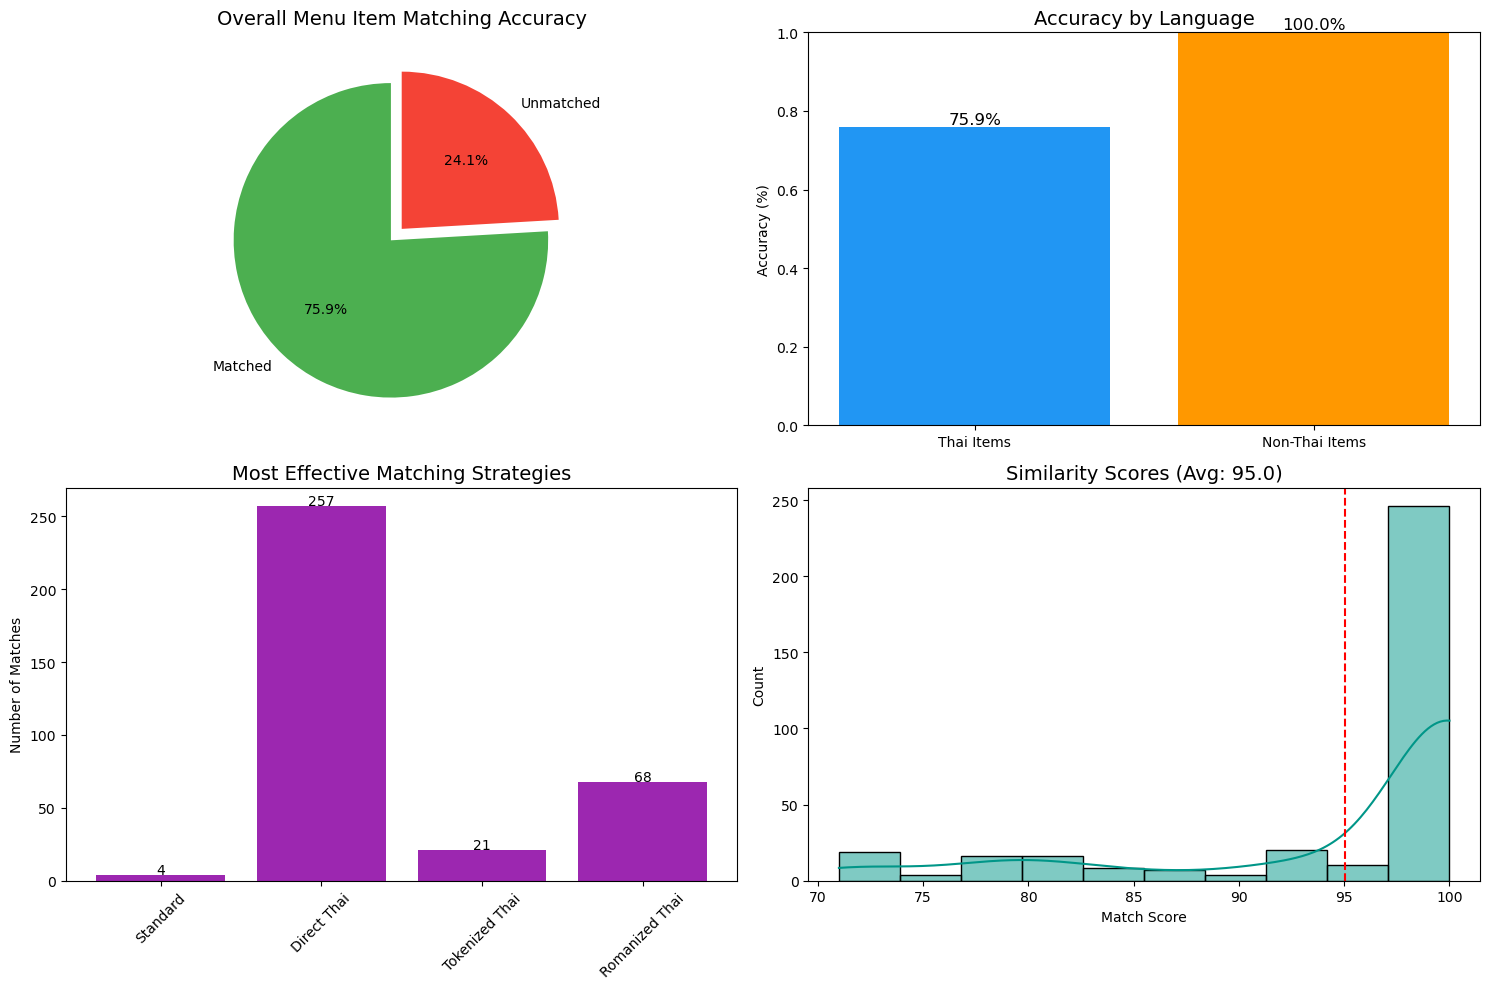


EXAMPLE MATCHES:
• Ground Truth: "ผัดพริกไทยดำ" ($170.00) → OCR: "Stir-fried Black Pepper ผัดพริกไทยดำ" ($160.00)
  Score: 100.0, Strategy: Direct Thai, Price Diff: 5.9%
  Has Thai: Yes
--------------------------------------------------------------------------------
• Ground Truth: "ผัดเผ็ด" ($170.00) → OCR: "Stir-fried Chili and Spices ผัดเผ็ด" ($160.00)
  Score: 100.0, Strategy: Direct Thai, Price Diff: 5.9%
  Has Thai: Yes
--------------------------------------------------------------------------------
• Ground Truth: "รอนานอร่อยแน่ (เมี่ยงปลากระพงเผาทรงเครื่อง)" ($340.00) → OCR: "Sea Bass with Herbs เมี่ยงปลากระพงเผาทรงเครื่อง" ($340.00)
  Score: 85.0, Strategy: Romanized Thai, Price Diff: 0.0%
  Has Thai: Yes
--------------------------------------------------------------------------------
• Ground Truth: "ลาบปลานิล" ($250.00) → OCR: "Spicy Minced Fish Salad ลาบปลานิล" ($250.00)
  Score: 100.0, Strategy: Direct Thai, Price Diff: 0.0%
  Has Thai: Yes
-------------------------------

In [12]:
import re
import pandas as pd
from fuzzywuzzy import fuzz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Try importing PyThaiNLP - if not available, provide simple fallbacks
try:
    from pythainlp import word_tokenize
    from pythainlp.transliterate import romanize
    thai_nlp_available = True
except ImportError:
    print("PyThaiNLP not installed. Install with: !pip install pythainlp")
    thai_nlp_available = False
    
    # Fallback functions
    def word_tokenize(text, engine=None):
        return text.split()
        
    def romanize(text):
        return text

# Enhanced preprocessing for Thai text
def preprocess_name(name):
    if pd.isna(name):
        return "", "", "", ""
    
    # Convert to string
    name = str(name)
    
    # Separate Thai and non-Thai parts
    # Thai Unicode range: \u0E00-\u0E7F
    thai_chars = re.findall(r'[\u0E00-\u0E7F]+', name)
    thai_part = ''.join(thai_chars)
    
    # Remove Thai characters to get non-Thai part
    non_thai_part = re.sub(r'[\u0E00-\u0E7F]', '', name).strip()
    
    # Process Thai part with specialized methods
    if thai_part and thai_nlp_available:
        try:
            # Tokenize Thai text (separates words correctly)
            tokenized = word_tokenize(thai_part, engine='newmm')
            # Join with spaces for better comparison
            spaced_thai = ' '.join(tokenized)
            
            # Create romanized version (Latin alphabet representation)
            romanized_thai = romanize(thai_part)
        except:
            spaced_thai = thai_part
            romanized_thai = thai_part
    else:
        spaced_thai = thai_part
        romanized_thai = thai_part
    
    # Process non-Thai part normally (as in original code)
    clean_non_thai = re.sub(r'[^\w\s]', ' ', non_thai_part)
    clean_non_thai = clean_non_thai.replace('.', '')
    clean_non_thai = re.sub(r'\s+', ' ', clean_non_thai).lower().strip()
    
    # Create standard clean name (for backward compatibility)
    clean_name = re.sub(r'[^\w\s]', ' ', name)
    clean_name = clean_name.replace('.', '')
    clean_name = re.sub(r'[฿-๙]', '', clean_name)
    clean_name = re.sub(r'\s+', ' ', clean_name).lower().strip()
    
    return clean_name, thai_part, spaced_thai, romanized_thai, clean_non_thai

# First, clean up the data by dropping NaN values in the key fields
actual_df_clean = actual_df.dropna(subset=['Name']).reset_index(drop=True)
ocr_df_clean = ocr_df.dropna(subset=['Name']).reset_index(drop=True)

# Convert Price columns to numeric to avoid type errors
actual_df_clean['Price'] = pd.to_numeric(actual_df_clean['Price'], errors='coerce')
ocr_df_clean['Price'] = pd.to_numeric(ocr_df_clean['Price'], errors='coerce')

# Now drop rows with invalid prices after conversion
actual_df_clean = actual_df_clean.dropna(subset=['Price']).reset_index(drop=True)
ocr_df_clean = ocr_df_clean.dropna(subset=['Price']).reset_index(drop=True)

# Apply enhanced preprocessing to both dataframes
actual_results = [preprocess_name(name) for name in actual_df_clean['Name']]
ocr_results = [preprocess_name(name) for name in ocr_df_clean['Name']]

# Unpack results
actual_df_clean['Clean_Name'] = [res[0] for res in actual_results]
actual_df_clean['Thai_Part'] = [res[1] for res in actual_results]
actual_df_clean['Spaced_Thai'] = [res[2] for res in actual_results]
actual_df_clean['Romanized_Thai'] = [res[3] for res in actual_results]
actual_df_clean['Clean_Non_Thai'] = [res[4] for res in actual_results]
actual_df_clean['Has_Thai'] = actual_df_clean['Thai_Part'].apply(lambda x: len(x) > 0)

ocr_df_clean['Clean_Name'] = [res[0] for res in ocr_results]
ocr_df_clean['Thai_Part'] = [res[1] for res in ocr_results]
ocr_df_clean['Spaced_Thai'] = [res[2] for res in ocr_results]
ocr_df_clean['Romanized_Thai'] = [res[3] for res in ocr_results]
ocr_df_clean['Clean_Non_Thai'] = [res[4] for res in ocr_results]
ocr_df_clean['Has_Thai'] = ocr_df_clean['Thai_Part'].apply(lambda x: len(x) > 0)

# Print sample to verify preprocessing
print("Ground Truth Sample with Thai Processing:")
print(actual_df_clean[['Name', 'Clean_Name', 'Thai_Part', 'Price', 'Has_Thai']].head())
print("\nOCR Sample with Thai Processing:")
print(ocr_df_clean[['Name', 'Clean_Name', 'Thai_Part', 'Price', 'Has_Thai']].head())

# Function to calculate similarity using multiple Thai-aware strategies
def calculate_thai_similarity(actual_item, ocr_item):
    # Calculate similarities using different strategies
    
    # Strategy 1: Standard fuzzy matching (original method - fallback)
    standard_score = fuzz.token_sort_ratio(actual_item['Clean_Name'], ocr_item['Clean_Name'])
    
    # Strategy 2: Direct Thai part comparison
    if actual_item['Thai_Part'] and ocr_item['Thai_Part']:
        thai_score = fuzz.ratio(actual_item['Thai_Part'], ocr_item['Thai_Part'])
    else:
        thai_score = 0
    
    # Strategy 3: Tokenized Thai comparison
    if actual_item['Spaced_Thai'] and ocr_item['Spaced_Thai']:
        spaced_thai_score = fuzz.token_sort_ratio(actual_item['Spaced_Thai'], ocr_item['Spaced_Thai'])
    else:
        spaced_thai_score = 0
    
    # Strategy 4: Romanized Thai comparison
    if actual_item['Romanized_Thai'] and ocr_item['Romanized_Thai']:
        romanized_score = fuzz.token_sort_ratio(actual_item['Romanized_Thai'], ocr_item['Romanized_Thai'])
    else:
        romanized_score = 0
    
    # Strategy 5: Non-Thai part comparison
    if actual_item['Clean_Non_Thai'] and ocr_item['Clean_Non_Thai']:
        non_thai_score = fuzz.token_sort_ratio(actual_item['Clean_Non_Thai'], ocr_item['Clean_Non_Thai'])
    else:
        non_thai_score = 0
    
    # Get the best score
    scores = [standard_score, thai_score, spaced_thai_score, romanized_score, non_thai_score]
    best_score = max(scores)
    best_strategy = scores.index(best_score)
    
    return best_score, scores, best_strategy

# Create a matches DataFrame to store results
matches = []
price_tolerance = 0.15  # Allow 15% price difference

# For each item in the actual (ground truth) menu
for i, actual_item in actual_df_clean.iterrows():
    best_match = None
    best_score = 0
    best_price_diff = float('inf')
    best_index = -1
    best_all_scores = []
    best_strategy = -1
    
    # Compare with each item in the OCR results
    for j, ocr_item in ocr_df_clean.iterrows():
        # Calculate name similarity with Thai-aware approach
        name_score, all_scores, strategy = calculate_thai_similarity(actual_item, ocr_item)
        
        # Calculate price difference (as percentage)
        try:
            actual_price = float(actual_item['Price'])
            ocr_price = float(ocr_item['Price'])
            if actual_price > 0:
                price_diff = abs(actual_price - ocr_price) / actual_price
            else:
                price_diff = float('inf')
        except (TypeError, ValueError):
            price_diff = float('inf')
        
        # Consider it a match if name similarity is high and price is close enough
        if name_score > 70 and price_diff <= price_tolerance:
            if name_score > best_score or (name_score == best_score and price_diff < best_price_diff):
                best_score = name_score
                best_match = ocr_item
                best_price_diff = price_diff
                best_index = j
                best_all_scores = all_scores
                best_strategy = strategy
    
    # Record the match or lack thereof
    if best_match is not None:
        matches.append({
            'Actual_Name': actual_item['Name'],
            'Actual_Price': actual_item['Price'],
            'Actual_Clean': actual_item['Clean_Name'],
            'OCR_Name': best_match['Name'],
            'OCR_Price': best_match['Price'],
            'OCR_Clean': best_match['Clean_Name'],
            'Name_Score': best_score,
            'All_Scores': best_all_scores,
            'Best_Strategy': best_strategy,
            'Price_Diff': best_price_diff,
            'Matched': True,
            'OCR_Index': best_index,
            'Has_Thai': actual_item['Has_Thai']
        })
    else:
        matches.append({
            'Actual_Name': actual_item['Name'],
            'Actual_Price': actual_item['Price'],
            'Actual_Clean': actual_item['Clean_Name'],
            'OCR_Name': None,
            'OCR_Price': None,
            'OCR_Clean': None,
            'Name_Score': 0,
            'All_Scores': [0, 0, 0, 0, 0],
            'Best_Strategy': -1,
            'Price_Diff': float('inf'),
            'Matched': False,
            'OCR_Index': -1,
            'Has_Thai': actual_item['Has_Thai']
        })

# Create a DataFrame of matches
matches_df = pd.DataFrame(matches)

# Calculate accuracy
match_count = matches_df['Matched'].sum()
total_items = len(actual_df_clean)
accuracy = match_count / total_items

print(f"\nOCR Accuracy with Thai-aware Fuzzy Matching: {accuracy:.2%}")

# Display detailed accuracy breakdown
thai_items = matches_df[matches_df['Has_Thai']]
non_thai_items = matches_df[~matches_df['Has_Thai']]

thai_accuracy = thai_items['Matched'].mean() if len(thai_items) > 0 else 0
non_thai_accuracy = non_thai_items['Matched'].mean() if len(non_thai_items) > 0 else 0

print(f"Thai items accuracy: {thai_accuracy:.2%} ({thai_items['Matched'].sum()}/{len(thai_items)} matched)")
print(f"Non-Thai items accuracy: {non_thai_accuracy:.2%} ({non_thai_items['Matched'].sum()}/{len(non_thai_items)} matched)")

# Strategy effectiveness
if match_count > 0:
    strategy_names = ['Standard', 'Direct Thai', 'Tokenized Thai', 'Romanized Thai', 'Non-Thai']
    matched_items = matches_df[matches_df['Matched']]
    strategy_counts = matched_items['Best_Strategy'].value_counts()
    
    print("\nMost effective matching strategies:")
    for strategy_id, count in strategy_counts.items():
        if strategy_id >= 0 and strategy_id < len(strategy_names):
            strategy_name = strategy_names[strategy_id]
            print(f"  • {strategy_name}: {count} matches ({count/match_count:.1%})")

# Create visualization for accuracy metrics
plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy pie chart
plt.subplot(2, 2, 1)
labels = ['Matched', 'Unmatched']
sizes = [match_count, total_items - match_count]
colors = ['#4CAF50', '#F44336']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.1, 0))
plt.title('Overall Menu Item Matching Accuracy', fontsize=14)

# Plot 2: Thai vs Non-Thai accuracy comparison
plt.subplot(2, 2, 2)
if len(thai_items) > 0 and len(non_thai_items) > 0:
    categories = ['Thai Items', 'Non-Thai Items']
    accuracies = [thai_accuracy, non_thai_accuracy]
    bars = plt.bar(categories, accuracies, color=['#2196F3', '#FF9800'])
    plt.title('Accuracy by Language', fontsize=14)
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 1.0)
    
    # Add text labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontsize=12)
else:
    plt.text(0.5, 0.5, 'Not enough data for Thai/Non-Thai comparison', 
            ha='center', va='center', fontsize=12)
    plt.axis('off')

# Plot 3: Matching strategy effectiveness
plt.subplot(2, 2, 3)
if match_count > 0:
    strategy_data = matched_items['Best_Strategy'].value_counts().sort_index()
    strategy_labels = [strategy_names[i] if i in strategy_data.index and i < len(strategy_names) else "Unknown" 
                      for i in strategy_data.index]
    plt.bar(strategy_labels, strategy_data.values, color='#9C27B0')
    plt.title('Most Effective Matching Strategies', fontsize=14)
    plt.ylabel('Number of Matches')
    plt.xticks(rotation=45)
    
    # Add text labels
    for i, count in enumerate(strategy_data.values):
        plt.text(i, count + 0.5, str(count), ha='center', fontsize=10)
else:
    plt.text(0.5, 0.5, 'No matches to analyze strategies', 
            ha='center', va='center', fontsize=12)
    plt.axis('off')

# Plot 4: Match score distribution
plt.subplot(2, 2, 4)
if match_count > 0:
    matched_scores = matches_df[matches_df['Matched']]['Name_Score']
    sns.histplot(matched_scores, bins=10, kde=True, color='#009688')
    plt.axvline(x=matched_scores.mean(), color='red', linestyle='--')
    plt.title(f'Similarity Scores (Avg: {matched_scores.mean():.1f})', fontsize=14)
    plt.xlabel('Match Score')
    plt.ylabel('Count')
else:
    plt.text(0.5, 0.5, 'No matches to analyze scores', 
            ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Show example matches and non-matches
if match_count > 0:
    print("\nEXAMPLE MATCHES:")
    print("="*80)
    for _, row in matches_df[matches_df['Matched']].sample(min(5, match_count)).iterrows():
        strategy_name = strategy_names[row['Best_Strategy']] if row['Best_Strategy'] >= 0 and row['Best_Strategy'] < len(strategy_names) else "Unknown"
        print(f"• Ground Truth: \"{row['Actual_Name']}\" (${row['Actual_Price']:.2f}) → OCR: \"{row['OCR_Name']}\" (${row['OCR_Price']:.2f})")
        print(f"  Score: {row['Name_Score']:.1f}, Strategy: {strategy_name}, Price Diff: {row['Price_Diff']*100:.1f}%")
        print(f"  Has Thai: {'Yes' if row['Has_Thai'] else 'No'}")
        print("-"*80)

if total_items - match_count > 0:
    print("\nEXAMPLE NON-MATCHES:")
    print("="*80)
    for _, row in matches_df[~matches_df['Matched']].sample(min(5, total_items - match_count)).iterrows():
        print(f"• Ground Truth: \"{row['Actual_Name']}\" (${row['Actual_Price']:.2f})")
        print(f"  Best Score: {row['Name_Score']:.1f}")
        print(f"  Has Thai: {'Yes' if row['Has_Thai'] else 'No'}")
        print("-"*80)